In [1]:
import pandas as pd 
import sklearn as sk
import numpy as np
from sklearn import metrics as met
import seaborn as sns 
from matplotlib import pyplot
import random
import pandas_datareader as web
from pandas_datareader import data as pdr
import yfinance as yfin
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler


In [2]:
"""
stock_names are all the stocks we want to capture, keep them in lists together based on same stock type
"""
stock_names = [['aapl', 'msft', 'goog', 'amzn', 'tsla', 'fb', 'pltr', 'twtr', 'orcl', 'nvda'],
          ['voo', 'spy', 'vde', 'gld', 'cibr', 'ivv', 'vcsh', 'spdn', 'fqal', 'ftec'],
          ['gold', 'xon', 'rio', 'vale', 'scco', 'lyb', 'btg', 'eva', 'bhp', 'nem'],
          ['btc-usd', 'eth-usd', 'sol-usd', 'matic-usd', 'avax-usd', 'link-usd', 'doge-usd', 'cro-usd', 'atom-usd', 'uni-usd'],
          ['ups', 'unp', 'cni', 'csx', 'nsc', 'fdx', 'ryaay', 'ual', 'aal', 'ksu'],
          ['jnj', 'pfe', 'unh', 'abbv', 'abt', 'cvs', 'bmy', 'ci', 'mrna', 'hca'],
          ['vz', 'cmcsa', 't', 'tmus', 'abnb', 'vod', 'zm', 'rblx', 'chtr', 'rci'],
          ['c', 'bac', 'mtb', 'lyg', 'frc', 'gs', 'bbva', 'wfc', 'sivb', 'ewbc']]
allstocktypes = ['tech','etf','commodities','crypto','transportation','healthcare','communications','banks']

In [53]:
def map_name_to_type(stocks: list,types: list) -> dict: 
    """
    Creates a map of all the stock names and their stock type, this will be useful for plotting later
    Args:
        stocks: The stocks to be mapped, this should be a list of lists where each embedded list is grouped by stock type (list)
        types: The stock types to be mapped, will be mapped in the same order they appear (list)
    Returns:
        dict: The map of stocks and stock types
    """
    mapped_names = {}
    for ix,stock_list in enumerate(stocks):
        for stock in stock_list:
            mapped_names.update({stock.upper():types[ix]})
            
    return(mapped_names)

stock_map = map_name_to_type(stock_names,allstocktypes)

In [134]:
#Building compiling function 

def grabstocks(stocktypes: list, stock_list: list) -> pd.DataFrame:
    """
    Uses yahoo finance to grab to stock data
    grabs all the columns for all the stocks in stock_names
    returns a concatinated dataframe of all the stocks across available weeks
    Args:
        stock_types: The stock types to be mapped, will be mapped in the same order they appear (list)
        stock_list: The stocks to be fetched, list of lists where each embedded list is grouped by stock type (list)
    Returns:
        pandas: Dataframe of all the columns from yahoo finance for each stock is stock_list, labeled with name and type
    """
    
    #created stocktypes for testing reasons
    
    # Initialize dict that will have all stocks and its type 
    
    stockdicts = {}
    fullstockdata = pd.DataFrame(columns = ['High','Low','Open','Close','Volume','Adj Close','Stock Name','Stock Type'])
    
    for ix,stocktype in enumerate(stock_list):
#         n = int(input("Enter number of "+str(stocktype)+" stocks(Type 0 for no stocks in sector): "))
#         stockls = list(map(str,input("\nEnter "+str(stocktype)+" stock symbols separated by spaces: ").strip().split()))[:n]
#         print(stockls)
        for stock in stocktype:
            try:
                stockdata = pdr.get_data_yahoo(str(stock.upper()), start=datetime(2018,2,8), end=datetime(2022,3, 10))
                stockdata['Stock Name'] = stock.upper()
                stockdata['Stock Type'] = stocktypes[ix]
                
                fullstockdata = pd.concat([fullstockdata,stockdata])
            except:
                print("Could not gather data on "+str(stock.upper()))
                pass
    return(fullstockdata)

stocks=grabstocks(stocktypes=allstocktypes, stock_list=stock_names).reset_index()
stocks.head()

Could not gather data on XON
Could not gather data on KSU


,index,High,Low,Open,Close,Volume,Adj Close,Stock Name,Stock Type
0,2018-02-08,40.25,38.7575,40.072498,38.787498,217562000.0,37.049877,AAPL,tech
1,2018-02-09,39.4725,37.560001,39.267502,39.102501,282690400.0,37.503056,AAPL,tech
2,2018-02-12,40.9725,39.377499,39.625,40.677502,243278000.0,39.013634,AAPL,tech
3,2018-02-13,41.1875,40.412498,40.487499,41.084999,130196800.0,39.404465,AAPL,tech
4,2018-02-14,41.884998,40.720001,40.759998,41.842499,162579600.0,40.130974,AAPL,tech


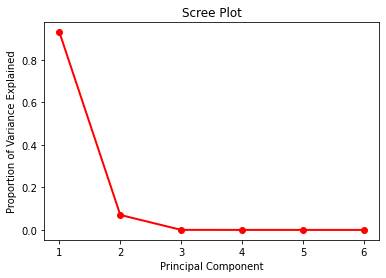

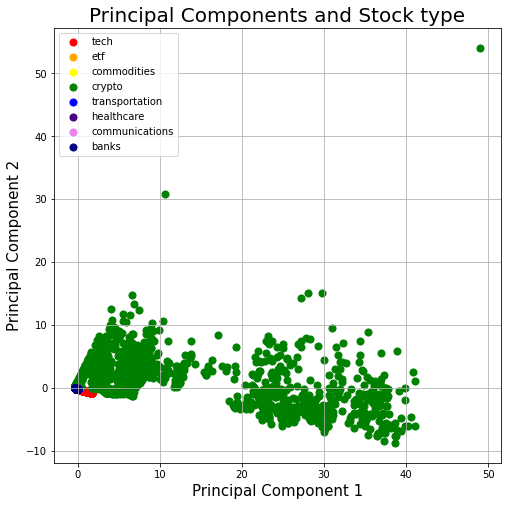

In [9]:
# Building PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# adjust features being used here. I used all features available initially
xvars = ['High','Low','Open','Close','Volume','Adj Close']
yvars=['Stock Type']

x = stocks.loc[:,xvars]
x = StandardScaler().fit_transform(x)

y = stocks.loc[:,yvars]

# Choose principal components that are responsile for at least 95% of the variance in the data
pca = PCA()
principalcomponents = pca.fit_transform(x)
# create pcs dataframe with all pcs and y variable(will reduce dimensionality of pcswithy later on)
pcs = pd.DataFrame(data = principalcomponents)

columnnames = []
for i,column in enumerate(pcs.columns):
    columnnames.append('Principal Component '+str(i+1))
pcs.columns = columnnames

pcs = pcs.reset_index(drop=True)
y = y.reset_index(drop=True)
pcswithy = pd.concat([pcs, y], axis = 1)

#Screeplot of principal components

import matplotlib.pyplot as plt

pcvalues = np.arange(pca.n_components_) + 1
plt.plot(pcvalues, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

#Scatter plot of First 2 Principal components on stocktype

allstocktypes = ['tech','etf','commodities','crypto','transportation','healthcare','communications','banks']

#number_of_colors = len(allstocktypes)
#color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]

color=['red','orange','yellow','green','blue','indigo','violet','navy']

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Principal Components and Stock type', fontsize = 20)

#Adjust x and y limits for better looking graph
#ax.set_xlim([-2.5, 10])
#ax.set_ylim([-2.5, 2.5])

for stocktype, color in zip(allstocktypes,color):
    indicesToKeep = pcswithy['Stock Type'] == stocktype
    ax.scatter(pcswithy.loc[indicesToKeep, 'Principal Component 1']
               , pcswithy.loc[indicesToKeep, 'Principal Component 2']
               , c = color
               , s = 50)
ax.legend(allstocktypes)
ax.grid()



In [11]:

"""Can use either of the following methods(or both):
1: Choose principal components responsible for at least 95% of variance in data
2. Find PCS that have eigenvalue greater than 1 and use those PCS"""


pcs = pd.DataFrame(data = principalcomponents)
columnnames = []
for i,column in enumerate(pcs.columns):
    columnnames.append('Principal Component '+str(i))
pcs.columns = columnnames


#Find principal components that have eigenvalue greater than 1. 

explained_var = {}
eigenvalues = list(pca.explained_variance_)
pcstokeep = []

for i in eigenvalues:
    if i<1:
        eigenvalues.remove(i)

for i,var in enumerate(eigenvalues):
    name = 'Principal Component '+str(i+1)
    explained_var.update({name:var})
    pcstokeep.append(name)
    
print(explained_var) 


# Add y value to principal component data frame 

pcs = pcs.reset_index(drop=True)
y = y.reset_index(drop=True)
pcswithy = pd.concat([pcs[pcstokeep], y], axis = 1)

# """
# Only the first Principal component has an eignvalue over 1(PC 2 has a very small eignevalue). Since I fit on all
# the features as well as us having a lot of data there are probably some overfitting issues here. Play around with 
# the features being used for the PCA. Will add a loading plot for better analysis. 

# Also found that we can use the PCA to make our other models run quicker so we can probably use this PCA in a 
# pipeline once we have decided on features to use. Here is a link for more info:

# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
# """


{'Principal Component 1': 5.5765011906118245, 'Principal Component 2': 0.0010765630990490541, 'Principal Component 3': 0.00010201528169677359}


# PCA with just Close Values

In [12]:
"""
We need to remove weekends since only the cryptos can trade on weekends
"""

stocks['dow'] = stocks['index'].dt.strftime("%A") 
stocks_updated = stocks.loc[(stocks['dow'] != 'Saturday') & (stocks['dow'] != 'Sunday')]

In [13]:
"""
Keep only the Close values for each stock
We pivot the data so each stock's close value is a column
"""

stocks_close = stocks_updated[['index','Close','Stock Name']]
stocks_close = stocks_close.pivot(index = 'index', columns = 'Stock Name', values = 'Close')
stocks_close

Stock Name,AAL,AAPL,ABBV,ABNB,ABT,AMZN,ATOM-USD,AVAX-USD,BAC,BBVA,...,UNP,UPS,VALE,VCSH,VDE,VOD,VOO,VZ,WFC,ZM
index,,,,,,,,,,,,,,,,,,,,,
2018-02-08,48.599998,38.787498,108.480003,NaN,56.27,1350.5,NaN,NaN,29.74,8.61,...,124.860001,109.279999,12.36,78.779999,90.93,28.4,236.789993,49.040001,55.400002,NaN
2018-02-09,48.360001,39.102501,111.300003,NaN,57.169998,1339.599976,NaN,NaN,30.33,8.61,...,127.279999,106.389999,12.91,78.739998,90.800003,28.540001,240.440002,49.880001,56.130001,NaN
2018-02-12,50.09,40.677502,111.93,NaN,57.41,1386.22998,NaN,NaN,31.120001,8.75,...,128.639999,106.309998,13.07,78.699997,92.440002,28.450001,243.740005,50.110001,56.5,NaN
2018-02-13,50.869999,41.084999,111.860001,NaN,57.639999,1414.51001,NaN,NaN,31.18,8.67,...,128.300003,107.559998,13.27,78.650002,92.029999,28.32,244.559998,50.080002,58.0,NaN
2018-02-14,51.07,41.842499,113.080002,NaN,58.279999,1451.050049,NaN,NaN,32.0,8.8,...,133.190002,106.599998,14.0,78.489998,93.540001,28.469999,247.759995,49.509998,59.549999,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-07,12.84,159.300003,149.449997,131.589996,118.860001,2749.060059,28.409777,71.880539,38.34,4.8,...,261.459991,201.179993,20.6,78.949997,106.379997,15.79,385.609985,54.68,45.810001,107.879997
2022-03-08,13.51,157.440002,147.149994,142.130005,116.110001,2720.290039,27.845692,72.918358,38.59,5.16,...,253.470001,203.410004,19.82,78.699997,107.459999,15.59,382.700012,53.25,46.459999,108.489998
2022-03-09,14.3,162.949997,148.839996,148.309998,118.389999,2785.580078,30.100052,77.716049,41.040001,5.53,...,253.669998,206.779999,18.719999,78.709999,104.559998,16.040001,392.899994,53.080002,49.16,109.080002


In [14]:
"""
If the stock didn't start trading until recently, it will have many weeks with NA values
We want to remove these
"""

stocks_not_new = stocks_close.loc[:, stocks_close.isna().sum() < 50]
stocks_not_new.dropna(inplace = True)
stocks_not_new

<ipython-input-14-fec07a38f1c1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_not_new.dropna(inplace = True)


Stock Name,AAL,AAPL,ABBV,ABT,AMZN,BAC,BBVA,BHP,BMY,BTC-USD,...,UNH,UNP,UPS,VALE,VCSH,VDE,VOD,VOO,VZ,WFC
index,,,,,,,,,,,,,,,,,,,,,
2018-02-08,48.599998,38.787498,108.480003,56.27,1350.5,29.74,8.61,44.759998,62.689999,8265.589844,...,216.460007,124.860001,109.279999,12.36,78.779999,90.93,28.4,236.789993,49.040001,55.400002
2018-02-09,48.360001,39.102501,111.300003,57.169998,1339.599976,30.33,8.61,45.759998,62.700001,8736.980469,...,220.960007,127.279999,106.389999,12.91,78.739998,90.800003,28.540001,240.440002,49.880001,56.130001
2018-02-12,50.09,40.677502,111.93,57.41,1386.22998,31.120001,8.75,46.799999,63.16,8926.570312,...,225.690002,128.639999,106.309998,13.07,78.699997,92.440002,28.450001,243.740005,50.110001,56.5
2018-02-13,50.869999,41.084999,111.860001,57.639999,1414.51001,31.18,8.67,47.740002,63.869999,8598.30957,...,226.639999,128.300003,107.559998,13.27,78.650002,92.029999,28.32,244.559998,50.080002,58.0
2018-02-14,51.07,41.842499,113.080002,58.279999,1451.050049,32.0,8.8,49.279999,65.349998,9494.629883,...,228.779999,133.190002,106.599998,14.0,78.489998,93.540001,28.469999,247.759995,49.509998,59.549999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-04,14.59,163.169998,150.559998,121.410004,2912.820068,40.950001,5.29,73.120003,69.360001,39137.605469,...,498.649994,264.630005,210.389999,20.15,79.32,104.730003,16.4,397.339996,55.110001,48.790001
2022-03-07,12.84,159.300003,149.449997,118.860001,2749.060059,38.34,4.8,72.400002,68.769997,38062.039062,...,486.869995,261.459991,201.179993,20.6,78.949997,106.379997,15.79,385.609985,54.68,45.810001
2022-03-08,13.51,157.440002,147.149994,116.110001,2720.290039,38.59,5.16,69.57,67.739998,38737.269531,...,473.459991,253.470001,203.410004,19.82,78.699997,107.459999,15.59,382.700012,53.25,46.459999


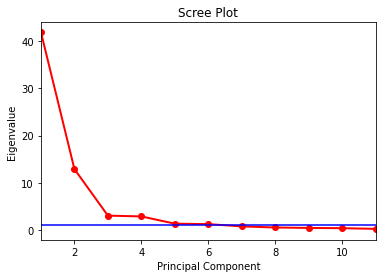

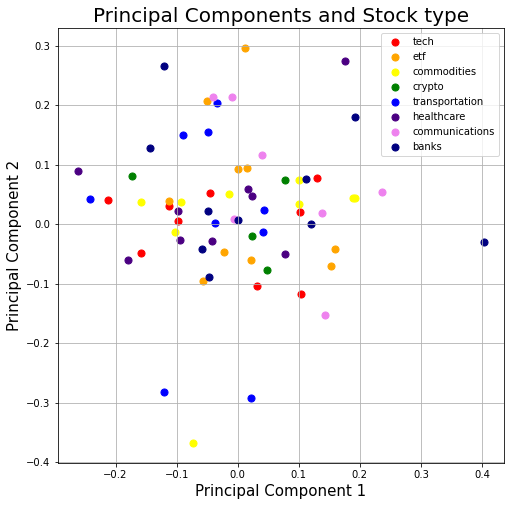

In [54]:
# Building PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

stocks_prep = stocks_not_new.reset_index()
x = stocks_prep.drop('index', axis = 1)

x = StandardScaler().fit_transform(x)
# y= stocks_prep['Stock Name']
# Choose principal components that are responsile for at least 95% of the variance in the data
pca = PCA()
principalcomponents = pca.fit_transform(x)
# create pcs dataframe with all pcs and y variable(will reduce dimensionality of pcswithy later on)
pcs = pd.DataFrame(data = principalcomponents)

columnnames = []
for i,column in enumerate(pcs.columns):
    columnnames.append('Principal Component '+str(i+1))
pcs.columns = columnnames

pcs = pcs.reset_index(drop=True)

pcswithy = pd.concat([pcs, y], axis = 1)

#Screeplot of principal components

import matplotlib.pyplot as plt

pcvalues = np.arange(pca.n_components_) + 1


plt.plot(pcvalues, pca.explained_variance_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.xlim([1, 11])
plt.axhline(y=1, color='b', linestyle='-')
plt.show()

#Scatter plot of First 2 Principal components on stocktype

allstocktypes = ['tech','etf','commodities','crypto','transportation','healthcare','communications','banks']

#number_of_colors = len(allstocktypes)
#color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]

color=['red','orange','yellow','green','blue','indigo','violet','navy']

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Principal Components and Stock type', fontsize = 20)

#Adjust x and y limits for better looking graph
# ax.set_xlim([-2.5, 10])
#ax.set_ylim([-2.5, 2.5])

loadings = pd.DataFrame(pca.components_ )
loadings= loadings[[0,1]]
loadings.columns =['PC1', 'PC2']
loadings['Stock_Name'] = list(stocks_not_new.columns)
loadings['Stock_Type'] = loadings['Stock_Name'].map(stock_map)

for stocktype, color in zip(allstocktypes,color):
    indicesToKeep = loadings['Stock_Type'] == stocktype
    ax.scatter(loadings.loc[indicesToKeep, 'PC1']
               , loadings.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(allstocktypes)
ax.grid()


The PCA seems to work very poorly for close values. I suspect this is because of the large difference between prices. Instead, lets try percent change

In [156]:
"""
We reach an issue with pct_change since the crypto stocks continue to trade on the weekends
From what I see, theres two potential approaches to this
Method 1:
    Drop all the weekend/mrkt close values, then calculate pct_change
    This means that the calculated change on mondays for cryptos will be based on is value from friday
Method 2:
    Calculate pct_change, then drop weekend/mrkt close
    This means that the calculated change on mondays for cryptos will be based on is value from sunday
Personally I prefer method 2
"""

stocks_not_new = stocks_not_new.sort_values('index')
stocks_diff_method_1 = stocks_not_new.pct_change().dropna()
stocks_diff_method_1 

Stock Name,AAL,AAPL,ABBV,ABT,AMZN,BAC,BBVA,BHP,BMY,BTC-USD,...,UNH,UNP,UPS,VALE,VCSH,VDE,VOD,VOO,VZ,WFC
index,,,,,,,,,,,,,,,,,,,,,
2018-02-09,-0.004938,0.008121,0.025996,0.015994,-0.008071,0.019839,0.000000,0.022341,0.000160,0.057030,...,0.020789,0.019382,-0.026446,0.044498,-0.000508,-0.001430,0.004930,0.015415,0.017129,0.013177
2018-02-12,0.035773,0.040279,0.005660,0.004198,0.034809,0.026047,0.016260,0.022727,0.007337,0.021700,...,0.021407,0.010685,-0.000752,0.012393,-0.000508,0.018062,-0.003153,0.013725,0.004611,0.006592
2018-02-13,0.015572,0.010018,-0.000625,0.004006,0.020401,0.001928,-0.009143,0.020086,0.011241,-0.036773,...,0.004209,-0.002643,0.011758,0.015302,-0.000635,-0.004435,-0.004569,0.003364,-0.000599,0.026549
2018-02-14,0.003932,0.018437,0.010907,0.011103,0.025832,0.026299,0.014994,0.032258,0.023172,0.104244,...,0.009442,0.038114,-0.008925,0.055011,-0.002034,0.016408,0.005297,0.013085,-0.011382,0.026724
2018-02-15,0.011749,0.033578,0.016095,0.020933,0.007381,0.006562,-0.001136,0.012784,0.055547,0.070753,...,-0.012064,0.005256,0.016041,0.009286,0.000255,-0.001711,0.009835,0.012956,0.004646,0.007893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-04,-0.071292,-0.018408,0.000997,0.003637,-0.015264,-0.036244,-0.062057,0.001644,0.003617,-0.078069,...,0.024785,0.035896,-0.009603,0.015625,0.000000,0.031518,-0.043174,-0.008088,0.008233,-0.047814
2022-03-07,-0.119945,-0.023718,-0.007372,-0.021003,-0.056220,-0.063736,-0.092628,-0.009847,-0.008506,-0.027482,...,-0.023624,-0.011979,-0.043776,0.022333,-0.004665,0.015755,-0.037195,-0.029521,-0.007803,-0.061078
2022-03-08,0.052181,-0.011676,-0.015390,-0.023136,-0.010465,0.006521,0.075000,-0.039088,-0.014977,0.017740,...,-0.027543,-0.030559,0.011085,-0.037864,-0.003167,0.010152,-0.012666,-0.007546,-0.026152,0.014189


In [157]:
"""
Some of the stocks dont have data that starts at '2018-02-09', I dont want to keep those so I get the right stock 
from the df above
I can also get only the days that the market is open from the df above
"""

desired_stocks = list(stocks_pct_change.columns)
desired_days = list(stocks_pct_change.index)
desired_days = [day.strftime('%Y-%m-%d') for day in desired_days]

In [158]:
"""
Back to the original df that contains weekends
"""

stocks_close_with_weekends = stocks[['index','Close','Stock Name']]
stocks_close_with_weekends = stocks_close_with_weekends.pivot(index = 'index', columns = 'Stock Name', values = 'Close')

In [159]:
"""
Keep the stocks that exist since '2018-02-09'
"""

desired_stocks_df = stocks_close_with_weekends[desired_stocks]

In [160]:
"""
Calculate pct_change and then keep only mrkt open days
"""

stocks_diff_method_2 = desired_stocks_df.pct_change().dropna()

stocks_diff_method_2 = stocks_diff_method_2.loc[desired_days]
stocks_diff_method_2

Stock Name,AAL,AAPL,ABBV,ABT,AMZN,BAC,BBVA,BHP,BMY,BTC-USD,...,UNH,UNP,UPS,VALE,VCSH,VDE,VOD,VOO,VZ,WFC
index,,,,,,,,,,,,,,,,,,,,,
2018-02-09,-0.004938,0.008121,0.025996,0.015994,-0.008071,0.019839,0.000000,0.022341,0.000160,0.057030,...,0.020789,0.019382,-0.026446,0.044498,-0.000508,-0.001430,0.004930,0.015415,0.017129,0.013177
2018-02-12,0.035773,0.040279,0.005660,0.004198,0.034809,0.026047,0.016260,0.022727,0.007337,0.097983,...,0.021407,0.010685,-0.000752,0.012393,-0.000508,0.018062,-0.003153,0.013725,0.004611,0.006592
2018-02-13,0.015572,0.010018,-0.000625,0.004006,0.020401,0.001928,-0.009143,0.020086,0.011241,-0.036773,...,0.004209,-0.002643,0.011758,0.015302,-0.000635,-0.004435,-0.004569,0.003364,-0.000599,0.026549
2018-02-14,0.003932,0.018437,0.010907,0.011103,0.025832,0.026299,0.014994,0.032258,0.023172,0.104244,...,0.009442,0.038114,-0.008925,0.055011,-0.002034,0.016408,0.005297,0.013085,-0.011382,0.026724
2018-02-15,0.011749,0.033578,0.016095,0.020933,0.007381,0.006562,-0.001136,0.012784,0.055547,0.070753,...,-0.012064,0.005256,0.016041,0.009286,0.000255,-0.001711,0.009835,0.012956,0.004646,0.007893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-04,-0.071292,-0.018408,0.000997,0.003637,-0.015264,-0.036244,-0.062057,0.001644,0.003617,-0.078069,...,0.024785,0.035896,-0.009603,0.015625,0.000000,0.031518,-0.043174,-0.008088,0.008233,-0.047814
2022-03-07,-0.119945,-0.023718,-0.007372,-0.021003,-0.056220,-0.063736,-0.092628,-0.009847,-0.008506,-0.009317,...,-0.023624,-0.011979,-0.043776,0.022333,-0.004665,0.015755,-0.037195,-0.029521,-0.007803,-0.061078
2022-03-08,0.052181,-0.011676,-0.015390,-0.023136,-0.010465,0.006521,0.075000,-0.039088,-0.014977,0.017740,...,-0.027543,-0.030559,0.011085,-0.037864,-0.003167,0.010152,-0.012666,-0.007546,-0.026152,0.014189


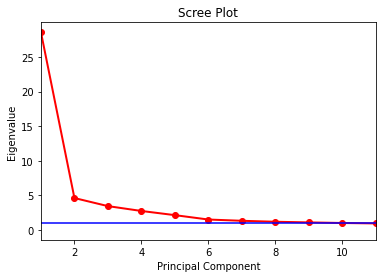

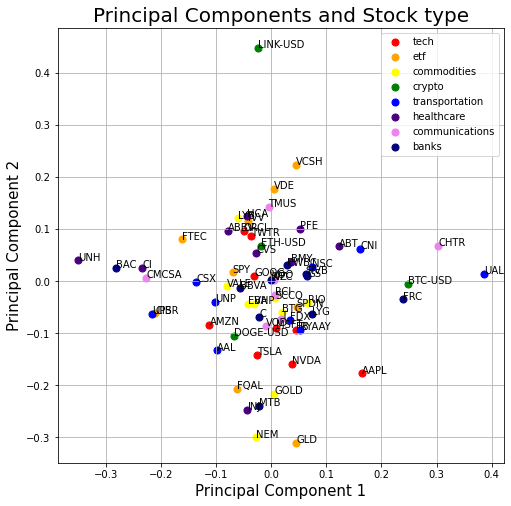

In [161]:
# Building PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# stocks_prep = stocks_diff_method_1.reset_index()
#or
stocks_prep = stocks_diff_method_2.reset_index()
x = stocks_prep.drop('index', axis = 1)

x = StandardScaler().fit_transform(x)
# y= stocks_prep['Stock Name']
# Choose principal components that are responsile for at least 95% of the variance in the data
pca = PCA()
principalcomponents = pca.fit_transform(x)
# create pcs dataframe with all pcs and y variable(will reduce dimensionality of pcswithy later on)
pcs = pd.DataFrame(data = principalcomponents)

columnnames = []
for i,column in enumerate(pcs.columns):
    columnnames.append('Principal Component '+str(i+1))
pcs.columns = columnnames

pcs = pcs.reset_index(drop=True)

pcswithy = pd.concat([pcs, y], axis = 1)

#Screeplot of principal components

import matplotlib.pyplot as plt

pcvalues = np.arange(pca.n_components_) + 1


plt.plot(pcvalues, pca.explained_variance_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.xlim([1, 11])
plt.axhline(y=1, color='b', linestyle='-')
plt.show()

#Scatter plot of First 2 Principal components on stocktype

allstocktypes = ['tech','etf','commodities','crypto','transportation','healthcare','communications','banks']

#number_of_colors = len(allstocktypes)
#color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]

color=['red','orange','yellow','green','blue','indigo','violet','navy']

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Principal Components and Stock type', fontsize = 20)

#Adjust x and y limits for better looking graph
# ax.set_xlim([-2.5, 10])
#ax.set_ylim([-2.5, 2.5])

loadings = pd.DataFrame(pca.components_ )
loadings= loadings[[0,1]]
loadings.columns =['PC1', 'PC2']
loadings['Stock_Name'] = list(stocks_pct_change.columns)
loadings['Stock_Type'] = loadings['Stock_Name'].map(stock_map)

for stocktype, color in zip(allstocktypes,color):
    indicesToKeep = loadings['Stock_Type'] == stocktype
    ax.scatter(loadings.loc[indicesToKeep, 'PC1']
               , loadings.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
    
for i, label in enumerate(list(stocks_pct_change.columns)):
    ax.annotate(label, (loadings.loc[i, 'PC1'], loadings.loc[i, 'PC2']))
ax.legend(allstocktypes)
ax.grid()

In [164]:
def find_closest_components(loadings: pd.DataFrame,stock: str) -> pd.DataFrame:
    """
    Find the stocks that are close based on principal components 1 and 2
    Hopefully, this should give an idea of which features could be useful in the classification
    Args:
        loadings: The loadings dataframe from the pca above (pandas)
        stock: the stock which you want to find the closest neighbors
    Returns:
        pandas: Dataframe of all the stocks sorted based on distance from input: stock
    """
    
    
    pc1_stock = loadings.loc[loadings['Stock_Name']==stock, 'PC1']
    pc2_stock = loadings.loc[loadings['Stock_Name']==stock, 'PC2']
    
    loadings['PC1_dist'] = abs(loadings['PC1'] - float(pc1_stock))
    loadings['PC2_dist'] = abs(loadings['PC2'] - float(pc2_stock))
    loadings['total_dist'] = loadings['PC1_dist'] + loadings['PC2_dist']
    
    closest_stocks = loadings[['Stock_Name','Stock_Type','total_dist']].sort_values('total_dist')
    return (closest_stocks)

find_closest_components(loadings,'AAPL').head(20)

,Stock_Name,Stock_Type,total_dist
1,AAPL,tech,0.000000
42,NVDA,tech,0.144450
47,RYAAY,transportation,0.194805
29,GOLD,commodities,0.199067
23,FB,tech,0.203019
37,LYG,banks,0.204203
26,FRC,banks,0.216774
54,TSLA,tech,0.226499
24,FDX,transportation,0.233013
46,RIO,commodities,0.234266
